### Importing Libraries

In [14]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

### Load Dataset

In [2]:
train_dataset = MNIST('/kaggle/working', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('/kaggle/working', train=False, download=True, transform=transforms.ToTensor())

train_dataset, dev_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.83), int(len(train_dataset) * 0.17)])

Extracting /kaggle/working/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw


Extracting /kaggle/working/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw


Extracting /kaggle/working/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw


Extracting /kaggle/working/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw
Processing...
Done!


/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


### Define Notebook Constants

In [3]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
total_dev_size = len(dev_dataset)

classes = 10
input_dim = 784

num_clients = 8
rounds = 30
batch_size = 128
epochs_per_client = 3
learning_rate = 2e-2

In [4]:
total_train_size, total_dev_size, total_test_size

(49800, 10200, 10000)

### Define utilities for GPU support

In [5]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

### Define FederatedNet class

In [7]:
class FederatedNet(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 7)
        self.conv2 = torch.nn.Conv2d(20, 40, 7)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(2560, 10)
        self.non_linearity = torch.nn.functional.relu
        self.track_layers = {'conv1': self.conv1, 'conv2': self.conv2, 'linear': self.linear}
    
    def forward(self, x_batch):
        out = self.conv1(x_batch)
        out = self.non_linearity(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        return out
    
    def get_track_layers(self):
        return self.track_layers
    
    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']
    
    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data, 
                'bias': self.track_layers[layer_name].bias.data
            }
        return parameters_dict
    
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))
    
    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)
    
    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history
    
    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

### Define Client class

In [8]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return net.get_parameters()

### Setup clients 

In [9]:
examples_per_client = total_train_size // num_clients
client_datasets = random_split(train_dataset, [min(i + examples_per_client, 
           total_train_size) - i for i in range(0, total_train_size, examples_per_client)])
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

### Start server

In [12]:
global_net = to_device(FederatedNet(), device)
history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
            new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
    global_net.apply_parameters(new_parameters)
    
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(dev_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    history.append((train_loss, dev_loss))

Start Round 1 ...
client_0: Loss = 0.438, Accuracy = 0.8659
client_1: Loss = 0.444, Accuracy = 0.8705
client_2: Loss = 0.4676, Accuracy = 0.8555
client_3: Loss = 0.4682, Accuracy = 0.8606
client_4: Loss = 0.4482, Accuracy = 0.8613
client_5: Loss = 0.4662, Accuracy = 0.8558
client_6: Loss = 0.477, Accuracy = 0.8529
client_7: Loss = 0.4952, Accuracy = 0.8454
After round 1, train_loss = 0.3834, dev_loss = 0.3865, dev_acc = 0.8877

Start Round 2 ...
client_0: Loss = 0.2844, Accuracy = 0.9168
client_1: Loss = 0.3033, Accuracy = 0.911
client_2: Loss = 0.3172, Accuracy = 0.9043
client_3: Loss = 0.3112, Accuracy = 0.911
client_4: Loss = 0.2966, Accuracy = 0.9105
client_5: Loss = 0.313, Accuracy = 0.9083
client_6: Loss = 0.3124, Accuracy = 0.909
client_7: Loss = 0.3161, Accuracy = 0.9056
After round 2, train_loss = 0.2818, dev_loss = 0.2831, dev_acc = 0.9186

Start Round 3 ...
client_0: Loss = 0.2087, Accuracy = 0.9379
client_1: Loss = 0.2272, Accuracy = 0.9348
client_2: Loss = 0.2359, Accuracy

client_0: Loss = 0.0419, Accuracy = 0.9873
client_1: Loss = 0.0544, Accuracy = 0.9827
client_2: Loss = 0.0509, Accuracy = 0.9858
client_3: Loss = 0.0611, Accuracy = 0.9828
client_4: Loss = 0.047, Accuracy = 0.9863
client_5: Loss = 0.0532, Accuracy = 0.9864
client_6: Loss = 0.0529, Accuracy = 0.9825
client_7: Loss = 0.0612, Accuracy = 0.9832
After round 20, train_loss = 0.0553, dev_loss = 0.0651, dev_acc = 0.9818

Start Round 21 ...
client_0: Loss = 0.04, Accuracy = 0.9886
client_1: Loss = 0.0532, Accuracy = 0.9828
client_2: Loss = 0.0474, Accuracy = 0.9855
client_3: Loss = 0.0591, Accuracy = 0.9834
client_4: Loss = 0.0464, Accuracy = 0.986
client_5: Loss = 0.0509, Accuracy = 0.9864
client_6: Loss = 0.051, Accuracy = 0.9831
client_7: Loss = 0.0595, Accuracy = 0.9821
After round 21, train_loss = 0.054, dev_loss = 0.0648, dev_acc = 0.9811

Start Round 22 ...
client_0: Loss = 0.0394, Accuracy = 0.9889
client_1: Loss = 0.052, Accuracy = 0.9838
client_2: Loss = 0.0465, Accuracy = 0.9868
clie

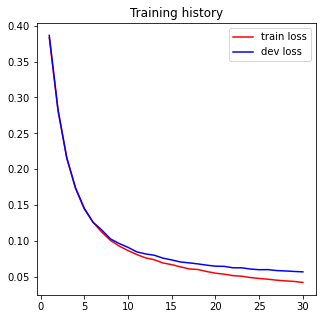

In [15]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Training history')
plt.show()